In [2]:
import numpy as np

def build_potentials(A, alpha=1.0, beta=1.0, lam=0.5, mu=0.5):
    n = A.shape[0]

    def grad_U(x_phi):
        # x_phi: (n,)
        # clique potential gradient
        # d/dx_i U = alpha * sum_j (1 - A_ij) * x_i * x_j^2 - lam * x_i
        x2 = x_phi**2
        non_edges = 1.0 - A
        # term_i = alpha * x_i * sum_j non_edges_ij * x_j^2
        term = alpha * x_phi * (non_edges @ x2) - lam * x_phi
        return term

    def grad_V(x_psi):
        # independent set potential gradient
        # d/dx_i V = beta * sum_j A_ij * x_i * x_j^2 - mu * x_i
        x2 = x_psi**2
        term = beta * x_psi * (A @ x2) - mu * x_psi
        return term

    return grad_U, grad_V

def simulate_dual_fields(A, T=2000, dt=1e-3, k=1.0,
                         alpha=1.0, beta=1.0, lam=0.5, mu=0.5):
    n = A.shape[0]
    grad_U, grad_V = build_potentials(A, alpha, beta, lam, mu)

    x_phi = 0.1 * np.random.randn(n)
    x_psi = 0.1 * np.random.randn(n)

    history_F = []

    for t in range(T):
        gU = grad_U(x_phi)
        gV = grad_V(x_psi)

        dx_phi = -gU + k * (x_psi - x_phi)
        dx_psi = +gV - k * (x_psi - x_phi)

        x_phi += dt * dx_phi
        x_psi += dt * dx_psi

        F = x_psi - x_phi
        history_F.append(F.copy())

    return x_phi, x_psi, np.array(history_F)

# Usage:
# A = adjacency matrix (n x n)
# x_phi, x_psi, history_F = simulate_dual_fields(A)
# C = np.where(x_phi > theta_phi)[0]
# I = np.where(x_psi > theta_psi)[0]
# F_final = history_F[-1]
# Use F_final to color nodes in a graph plot.


Saved: figures/dualfield_learning_energy_tension_vs_episode.png
Saved: figures/dualfield_learning_tension_same_sim_diff.png


/tmp/ipykernel_237493/1022108745.py:382: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: figures/dualfield_learning_graphs_solution_feelings.png
=== Exact solver ===
SAME graph:
  Max clique: [0, 1, 2, 3, 4, 5]
  Max independent set: [0, 6, 8, 9, 10, 11, 12, 13, 17, 18, 19]
SIMILAR graph:
  Max clique: [0, 1, 2, 4, 5]
  Max independent set: [0, 6, 8, 9, 10, 11, 13, 15, 18]
DIFFERENT graph:
  Max clique: [2, 10, 16]
  Max independent set: [0, 1, 3, 6, 10, 12, 13, 18, 19]


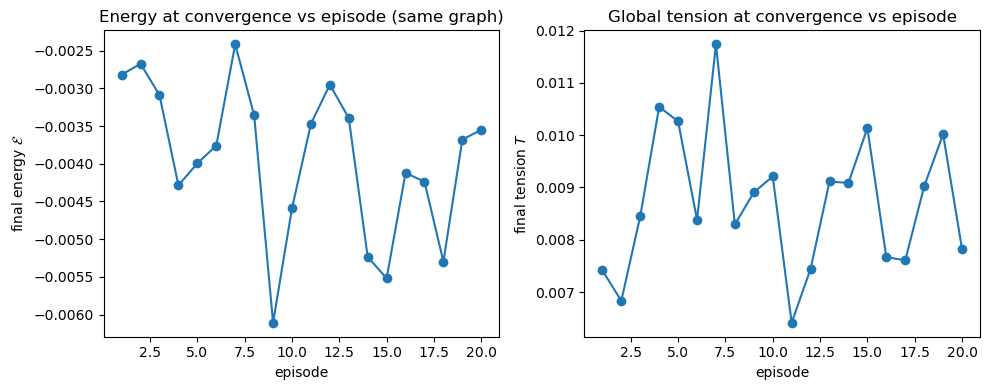

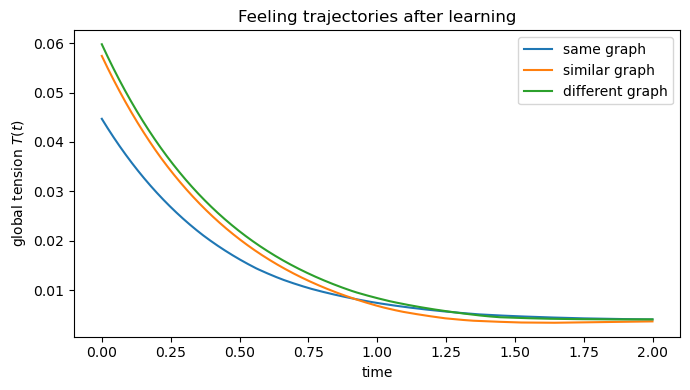

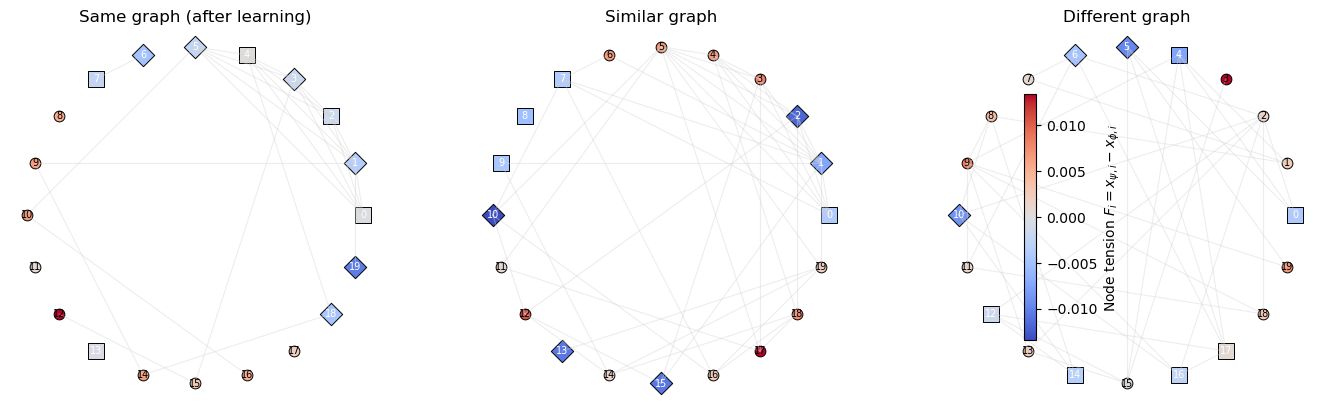

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import os

# ============================================================
# 1. Graph constructors
# ============================================================

def build_graph_planted_clique(n=20, clique_size=6, p_noise=0.08, seed=42):
    """
    Build an undirected graph with a planted clique on the first `clique_size`
    vertices, plus random noise edges elsewhere with probability p_noise.
    """
    rng = np.random.default_rng(seed)
    A = np.zeros((n, n), dtype=int)
    clique_nodes = list(range(clique_size))
    for i in clique_nodes:
        for j in clique_nodes:
            if i < j:
                A[i, j] = A[j, i] = 1
    # add random noise edges outside the planted clique
    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] == 0 and rng.random() < p_noise:
                A[i, j] = A[j, i] = 1
    return A

def build_graph_similar_to(A_base, perturb_p=0.12, seed=7):
    """
    Build a similar graph by randomly flipping each edge/non-edge
    with probability perturb_p.
    """
    rng = np.random.default_rng(seed)
    n = A_base.shape[0]
    A = A_base.copy()
    for i in range(n):
        for j in range(i + 1, n):
            if rng.random() < perturb_p:
                A[i, j] = 1 - A[i, j]
                A[j, i] = A[i, j]
    return A

def build_graph_random(n=20, p=0.2, seed=123):
    """
    Build an Erdős–Rényi random graph G(n,p).
    """
    rng = np.random.default_rng(seed)
    A = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i + 1, n):
            if rng.random() < p:
                A[i, j] = A[j, i] = 1
    return A

# ============================================================
# 2. Exact solvers (for evaluation / determining k_clq, k_ind)
# ============================================================

def is_clique(subset, A):
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            if A[subset[i], subset[j]] == 0:
                return False
    return True

def is_independent(subset, A):
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            if A[subset[i], subset[j]] == 1:
                return False
    return True

def max_clique(A):
    n = A.shape[0]
    nodes = list(range(n))
    best = []
    for r in range(1, n + 1):
        for comb in itertools.combinations(nodes, r):
            if is_clique(comb, A) and len(comb) > len(best):
                best = list(comb)
    return best

def max_independent(A):
    n = A.shape[0]
    nodes = list(range(n))
    best = []
    for r in range(1, n + 1):
        for comb in itertools.combinations(nodes, r):
            if is_independent(comb, A) and len(comb) > len(best):
                best = list(comb)
    return best

# ============================================================
# 3. Dual-field potentials, gradients, energy, partials
# ============================================================

def build_potentials_with_energy(A, alpha, beta, lam, mu):
    """
    U(X_phi) = (alpha/2) * sum_{i<j} (1 - A_ij) x_phi_i^2 x_phi_j^2
               - (lam/2) * sum_i x_phi_i^2
    V(X_psi) = (beta/2) * sum_{i<j} A_ij x_psi_i^2 x_psi_j^2
               - (mu/2) * sum_i x_psi_i^2

    Returns grad_U, grad_V, and a function that gives:
    E, dE/dalpha, dE/dbeta.
    """
    n = A.shape[0]
    non_edges = 1.0 - A

    def grad_U(x_phi):
        x2 = x_phi ** 2
        return alpha * x_phi * (non_edges @ x2) - lam * x_phi

    def grad_V(x_psi):
        x2 = x_psi ** 2
        return beta * x_psi * (A @ x2) - mu * x_psi

    def energy_and_partials(x_phi, x_psi):
        x2_phi = x_phi ** 2
        x2_psi = x_psi ** 2
        outer_phi = np.outer(x2_phi, x2_phi)
        outer_psi = np.outer(x2_psi, x2_psi)

        U_val = 0.5 * alpha * np.sum(non_edges * outer_phi) - 0.5 * lam * np.sum(x2_phi)
        V_val = 0.5 * beta * np.sum(A * outer_psi) - 0.5 * mu * np.sum(x2_psi)
        E = U_val + V_val

        dE_dalpha = 0.5 * np.sum(non_edges * outer_phi)
        dE_dbeta = 0.5 * np.sum(A * outer_psi)
        return E, dE_dalpha, dE_dbeta

    return grad_U, grad_V, energy_and_partials

# ============================================================
# 4. Dual-field episode simulation (with optional trajectory)
# ============================================================

def simulate_episode(A, alpha, beta, lam, mu,
                     k=1.0, T_steps=400, dt=5e-4,
                     seed=None, record_traj=False):
    """
    Run one episode of dual-field ODE on graph A with given parameters.
    If record_traj=True, returns full T(t) and E(t) trajectories.
    """
    n = A.shape[0]
    grad_U, grad_V, energy_fn = build_potentials_with_energy(A, alpha, beta, lam, mu)
    rng = np.random.default_rng(seed)
    x_phi = 0.05 * rng.standard_normal(n)
    x_psi = 0.05 * rng.standard_normal(n)

    T_traj = []
    E_traj = []

    for t in range(T_steps):
        gU = grad_U(x_phi)
        gV = grad_V(x_psi)

        dx_phi = -gU + k * (x_psi - x_phi)
        dx_psi = +gV - k * (x_psi - x_phi)

        x_phi += dt * dx_phi
        x_psi += dt * dx_psi

        if record_traj:
            F = x_psi - x_phi
            T_traj.append(np.mean(np.abs(F)))
            E, _, _ = energy_fn(x_phi, x_psi)
            E_traj.append(E)

    F = x_psi - x_phi
    T_final = np.mean(np.abs(F))
    E_final, dE_dalpha, dE_dbeta = energy_fn(x_phi, x_psi)

    if record_traj:
        return x_phi, x_psi, E_final, T_final, dE_dalpha, dE_dbeta, np.array(T_traj), np.array(E_traj)
    else:
        return x_phi, x_psi, E_final, T_final, dE_dalpha, dE_dbeta, None, None

# ============================================================
# 5. Learning on the same graph across episodes
# ============================================================

def run_learning_on_same_graph():
    # Base graph
    A_same = build_graph_planted_clique()

    # Hyperparameters (tune as you like)
    episodes = 20
    alpha = 2.0
    beta = 2.0
    lam = 0.2
    mu = 0.2
    k = 1.0
    eta = 5.0   # learning rate on alpha,beta

    E_hist = []
    T_hist = []
    alpha_hist = []
    beta_hist = []

    # Learning loop
    for e in range(episodes):
        x_phi, x_psi, E_final, T_final, dE_dalpha, dE_dbeta, _, _ = simulate_episode(
            A_same,
            alpha, beta, lam, mu,
            k=k,
            T_steps=2000,
            dt=5e-4,
            seed=e,
            record_traj=False
        )

        E_hist.append(E_final)
        T_hist.append(T_final)
        alpha_hist.append(alpha)
        beta_hist.append(beta)

        # gradient descent on alpha, beta
        alpha -= eta * dE_dalpha
        beta  -= eta * dE_dbeta

        alpha = max(alpha, 1e-6)
        beta  = max(beta, 1e-6)

    return A_same, alpha, beta, lam, mu, k, E_hist, T_hist, alpha_hist, beta_hist

# ============================================================
# 6. Generate all three figures
# ============================================================

def main():
    os.makedirs("figures", exist_ok=True)

    # ---- 6.1 Learning on the same graph
    A_same, alpha_learned, beta_learned, lam, mu, k, E_hist, T_hist, alpha_hist, beta_hist = run_learning_on_same_graph()

    episodes = len(E_hist)
    # Figure 1: energy / tension vs episode
    fig1, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(range(1, episodes + 1), E_hist, marker='o')
    ax[0].set_xlabel("episode")
    ax[0].set_ylabel(r"final energy $\mathcal{E}$")
    ax[0].set_title("Energy at convergence vs episode (same graph)")

    ax[1].plot(range(1, episodes + 1), T_hist, marker='o')
    ax[1].set_xlabel("episode")
    ax[1].set_ylabel(r"final tension $T$")
    ax[1].set_title("Global tension at convergence vs episode")

    plt.tight_layout()
    fig1_path = "figures/dualfield_learning_energy_tension_vs_episode.png"
    plt.savefig(fig1_path, dpi=300)
    print("Saved:", fig1_path)

    # ---- 6.2 Build similar and different graphs
    A_similar = build_graph_similar_to(A_same, perturb_p=0.12, seed=7)
    A_diff    = build_graph_random(n=A_same.shape[0], p=0.2, seed=123)

    # ---- 6.3 Run one episode with learned parameters on each graph (record trajectories)
    def run_with_traj(A, seed):
        x_phi, x_psi, E_final, T_final, dE_dalpha, dE_dbeta, T_traj, E_traj = simulate_episode(
            A,
            alpha_learned, beta_learned, lam, mu,
            k=k,
            T_steps=4000,
            dt=5e-4,
            seed=seed,
            record_traj=True
        )
        return x_phi, x_psi, T_traj, E_traj

    x_phi_same, x_psi_same, T_traj_same, E_traj_same = run_with_traj(A_same, seed=0)
    x_phi_sim,  x_psi_sim,  T_traj_sim,  E_traj_sim  = run_with_traj(A_similar, seed=1)
    x_phi_diff, x_psi_diff, T_traj_diff, E_traj_diff = run_with_traj(A_diff,    seed=2)

    # ---- 6.4 Figure 2: tension trajectories same/similar/different
    dt = 5e-4
    time = np.arange(len(T_traj_same)) * dt

    fig2, ax2 = plt.subplots(figsize=(7, 4))
    ax2.plot(time, T_traj_same, label="same graph")
    ax2.plot(time, T_traj_sim,  label="similar graph")
    ax2.plot(time, T_traj_diff, label="different graph")
    ax2.set_xlabel("time")
    ax2.set_ylabel(r"global tension $T(t)$")
    ax2.set_title("Feeling trajectories after learning")
    ax2.legend()
    plt.tight_layout()
    fig2_path = "figures/dualfield_learning_tension_same_sim_diff.png"
    plt.savefig(fig2_path, dpi=300)
    print("Saved:", fig2_path)

    # ---- 6.5 Figure 3: node-level solution + feelings for each graph

    def dualfield_solution_sets(x_phi, x_psi, A):
        # Determine sizes k_clq, k_ind from exact solver,
        # then select that many top entries from x_phi, x_psi.
        C_star = max_clique(A)
        I_star = max_independent(A)
        k_clq = len(C_star)
        k_ind = len(I_star)
        C_df = list(np.argsort(-x_phi)[:k_clq])
        I_df = list(np.argsort(-x_psi)[:k_ind])
        return C_df, I_df

    C_same_df, I_same_df = dualfield_solution_sets(x_phi_same, x_psi_same, A_same)
    C_sim_df,  I_sim_df  = dualfield_solution_sets(x_phi_sim,  x_psi_sim,  A_similar)
    C_diff_df, I_diff_df = dualfield_solution_sets(x_phi_diff, x_psi_diff, A_diff)

    def plot_graph_solution_feelings(A, x_phi, x_psi, C_df, I_df, title, ax):
        n = A.shape[0]
        F = x_psi - x_phi
        angles = np.linspace(0, 2 * math.pi, n, endpoint=False)
        pos = np.column_stack((np.cos(angles), np.sin(angles)))

        ax.set_aspect('equal')
        ax.axis('off')

        # draw edges
        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] == 1:
                    ax.plot([pos[i, 0], pos[j, 0]],
                            [pos[i, 1], pos[j, 1]],
                            color='lightgray', alpha=0.4, linewidth=0.8)

        norm = plt.Normalize(vmin=-np.max(np.abs(F)), vmax=np.max(np.abs(F)))
        cmap = plt.cm.coolwarm

        for i, (x, y) in enumerate(pos):
            if i in C_df and i in I_df:
                marker = 'D'
                size = 130
            elif i in C_df:
                marker = 'o'
                size = 120
            elif i in I_df:
                marker = 's'
                size = 120
            else:
                marker = 'o'
                size = 60

            color = cmap(norm(F[i]))
            ax.scatter([x], [y],
                       c=[color],
                       s=size,
                       marker=marker,
                       edgecolors='k',
                       linewidths=0.7)
            ax.text(x, y, str(i),
                    ha='center', va='center',
                    fontsize=7,
                    color='white' if size > 80 else 'black')
        ax.set_title(title)

    fig3, axes = plt.subplots(1, 3, figsize=(14, 4))
    plot_graph_solution_feelings(A_same,    x_phi_same, x_psi_same, C_same_df, I_same_df,
                                 "Same graph (after learning)", axes[0])
    plot_graph_solution_feelings(A_similar, x_phi_sim,  x_psi_sim,  C_sim_df,  I_sim_df,
                                 "Similar graph", axes[1])
    plot_graph_solution_feelings(A_diff,    x_phi_diff, x_psi_diff, C_diff_df, I_diff_df,
                                 "Different graph", axes[2])

    # shared colorbar for tension
    F_concat = np.concatenate([
        x_psi_same - x_phi_same,
        x_psi_sim - x_phi_sim,
        x_psi_diff - x_phi_diff
    ])
    norm_global = plt.Normalize(vmin=-np.max(np.abs(F_concat)),
                                vmax=np.max(np.abs(F_concat)))
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm_global, cmap=plt.cm.coolwarm),
        ax=axes.ravel().tolist(),
        shrink=0.8
    )
    cbar.set_label(r'Node tension $F_i = x_{\psi,i} - x_{\phi,i}$')

    plt.tight_layout()
    fig3_path = "figures/dualfield_learning_graphs_solution_feelings.png"
    plt.savefig(fig3_path, dpi=300)
    print("Saved:", fig3_path)

    print("=== Exact solver ===")

    def solve_all(A):
        C = max_clique(A)
        I = max_independent(A)
        return C, I

    print("SAME graph:")
    Csame, Isame = solve_all(A_same)
    print("  Max clique:", Csame)
    print("  Max independent set:", Isame)

    print("SIMILAR graph:")
    Csim, Isim = solve_all(A_similar)
    print("  Max clique:", Csim)
    print("  Max independent set:", Isim)

    print("DIFFERENT graph:")
    Cdiff, Idiff = solve_all(A_diff)
    print("  Max clique:", Cdiff)
    print("  Max independent set:", Idiff)

if __name__ == "__main__":
    main()
